In [ ]:
%pip install scipy numpy matplotlib xarray pathlib nitime 

## Download dataset

In [1]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')

In [2]:
import xarray as xr
from pathlib import Path

### Load dataset
Run cells below to load dataset and extract relevant data

In [3]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

#### Extract LFP data

In [4]:
# extract data

lfp_trials = dataset['lfp_trials']

channels_depth = dataset['channel_depth']
sampling_frequency_lfp = dataset.sampling_frequency_lfp # Hz
time_lfp = lfp_trials.time_from_stimulus_onset_lfp.values # ms

#### Extract spike data

In [5]:
spike_counts_LGN = dataset['spike_counts_LGN']
spike_counts_V1 = dataset['spike_counts_V1']
spike_counts_LM = dataset['spike_counts_LM']

sampling_frequency_spikes = dataset.sampling_frequency_spikes # Hz
time_spikes = dataset['time_from_stimulus_onset_spikes'] # ms

# Introduction

In this notebook, you will learn how to apply frequency analysis methods to real LFP and spike data.

## Section 1

### Calculating Trial Averaged Frequency Spectra

To reduce the prominence of noise in our results, we often calculate the average across multiple trials. When your data from each trial or channel is of the same length, you can simply apply the functions to compute the power spectra directly to the data and you will get spectra calculated for each trial and channel (or cells, in the case of spike data) organized the same way as your original data.

| Code                                         | Description                                                          |
| ---                                          | ---                                                                  |
| `freqs, power_density = signal.welch(data, fs = sampling_frequency)` | Calculate the power spectral density using Welch's method |
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` defines the colormap and the interpolation applied to the plot, respectively. |
| `np.mean(data, axis = (dim_num1, dim_num2))` or `data.mean(axis = dim_num1, dim_num2)` | Calculate the average of the data across **both** the `dim_num1` and the `dim_num2` dimensions of the array. |
| `plt.plot(x, y)` | Plot y values against x values. |
| `plt.semilogx(x, y)` | Plot y values against x values with a logarithmic x-axis and linear y-axis. |
| `plt.semilogy(x, y)` | Plot y values against x values with a logarithmic y-axis and a linear x-axis. |
| `plt.loglog(x, y)` | Plot y values against x values with logarithmic x- **and** y-axis. |
| `plt.xlim([some_lower_xlim, some_upper_xlim])`                 | Limit the x-axis in a plot to be betwen the numbers ``some_lower_xlim`` and ``some_upper_xlim``. |
| `np.arange(start, stop, step)` | Makes an array with all the integers between two values, with a given spacing |


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

**Example**: Calculate the power spectrum for all trials and all cells containing spike data from **LM** with Welch's method. Make a 2D colormap of the trial averaged power spectrum with the `freqs` on the x-axis and cell numbers in LM (`cell_nrs_LM`) on the y-axis.

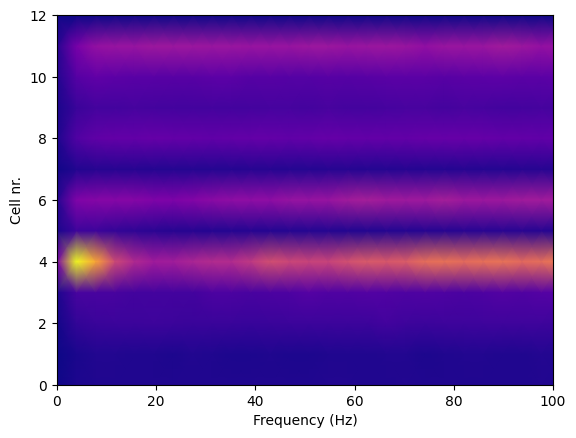

In [17]:
# solution

freqs, psd_spikes_LM_trials = signal.welch(spike_counts_LM, sampling_frequency_spikes)

cell_nrs_LM = np.arange(spike_counts_LM.shape[0])
plt.pcolormesh(freqs, cell_nrs_LM, psd_spikes_LM_trials.mean(axis=1), cmap = 'plasma', shading='gouraud')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Cell nr.')
plt.xlim([0,100]);

**Exercise**: Calculate the power spectrum for all trials and all cells containing spike data from **V1** with Welch's method. Make a 2D colormap of the trial averaged power spectrum with the ``freqs`` on the x-axis and cell numbers in V1 (`cell_nrs_V1`) on the y-axis.

*Hint*: To focus on a subset of frequencies, for example the frequencies below 100 Hz, you can limit the x-axis to focus on them using `plt.xlim([lower_limit, upper_limit])` (insert numbers for `lower_limit` and `upper_limit`).

In [18]:
# solution


**Exercise**: Calculate the power spectrum for all trials and all cells containing spike data from **LGN** with Welch's method. make a 2D colormap of the trial averaged power spectrum with the ``freqs`` on the x-axis and cell numbers on the y-axis.

Do you notice anything different with this plot compared to the equivalent plots for V1 and LM spikes? Is there a frequency where the power is notably higher for some cells? 

In [19]:
# solution


**Exercise**: Calculate the power spectrum for all trials and channels containing **LFP** data from V1 with Welch's method. Compute the trial averaged power spectrum and make a 2D colormap with ``freqs`` on the x-axis and ``channels_depth`` on the y-axis.

NB: Make sure to use the sampling frequency for the LFP (`sampling_frequency_lfp`) in the function for Welch's method.

In [20]:
# solution


**Exercise**: From the LFP spectrum computed in the exercise above, calculate the average power spectrum for **V1 LFP** across **both channels and trials**. Make a 1D plot of that average against frequencies.

In [21]:
# solution


**Exercise**: It's often useful (and common practice) to plot frequency spectra on logarithmic axes rather than on linear axes. Create the same plot as above, but with a logarithmic x-axis (and a linear y-axis).

In [22]:
# solution


**Exercise**: Create the same plot as above, but with a logarithmic y-axis (and a linear x-axis).

At approximately which frequencies are there bumps in the spectrum?

In [23]:
# solution


**Exercise**: Create the same plot as above, but with **both** axes logarithmic.

In [24]:
# solution


**Example**: Calculate the power spectrum for **V1** spikes and average across **both cells and trials**. Make a 1D plot of the average power spectral density against frequencies.

In [25]:
# solution


**Example**: Calculate the power spectrum for **LGN** spikes and average across **both cells and trials**. Make a 1D plot of the power spectral density against frequencies.

Is there a correspondence between any of the frequencies where you find peaks in the power spectrum for LGN spikes and where you find peaks in the spectrum for V1 LFP?

In [26]:
# solution


## Section 2

## Iteration with For Loops

There are different kinds of loops in programming languages that are used for different purposes. 
When you know when to start and stop an iteration, for loops are the most appropriate. For example, when you want to start at the first trial and stop at the last trial, or start at the 5th trial and stop at the 10th trial, you can specify that with a for loop. Going through the 5th to the 10th trial would have the following structure in Python code:
```python
for itrial in range(4, 10):
    # do some analysis of the data in the trial with index "itrial"
```

| Code                                         | Description                                                          |
| ---                                          | ---                                                                  |
| `for letter in ["a", "b", "c"]:` <br> &nbsp;&nbsp;&nbsp;&nbsp; `print(letter)` | Print every `letter` in the list `["a", "b", "c"]`|
| `for i in range(5):` <br> &nbsp;&nbsp;&nbsp;&nbsp; `print(i)` | Print every number `i` between 0 and 5 (not including 5)|
| `for i in range(2, 7):` <br> &nbsp;&nbsp;&nbsp;&nbsp; `print(i)` | Print every number `i` between 2 and 7 (not including 7)|
| `for i in range(1, 10, 2):` <br> &nbsp;&nbsp;&nbsp;&nbsp; `print(i)` | Print eververy **second** number `i` between 1 and 10 (not including 10)|
| `for x_i in x:` <br> &nbsp;&nbsp;&nbsp;&nbsp; `print(x_i)` | Print every element `x_i` in the collection `x`|
| `for x_i in x:` <br> &nbsp;&nbsp;&nbsp;&nbsp; `for y_i in y`: <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `print(x_i, y_i)` | Print every element `x_i` and `y_i` in the collections `x` and `y`|
| `new_list = []` or `new_list = list()`| Initialize an empty list named `new_list` |
| `new_list.append(element)`| Append an element to the list `new_list` |



**Exercise**: Write a for loop that prints the numbers **0** to **9**.

**Exercise**: Write a for loop that prints the numbers **5** to **10**.

**Exercise**: Write a for loop that counts from **0** to **100** in steps of **10**.

**Exercise**: Use a loop to print all `fruits` and `colors`, for example `banana is yellow"`.

In [27]:
fruits = ["banana", "orange", "cherry"]
colors= ["yellow", "orange", "green"];

**Example**: Write a loop that calculates the square of each element in `numbers` and stores the result in a new list called `squared_numbers`. Display the `squared_numbers` list at the end to check that it is correct.


In [28]:
numbers = [4, 6, 12, 50]

squared_numbers = []

for i in range(len(numbers)):
    num_squared = numbers[i]**2
    squared_numbers.append(num_squared)

squared_numbers

[16, 36, 144, 2500]

**Exercise**: Write a loop that multiplies each element in the list `numbers` by 4 and store the results in a new list called `multiplied_numbers`. Display `multiplied_numbers` to check that it is correct.

In [29]:
# solution

numbers = [4, 6, 12, 50]



**Exercise**: Write a loop that print out `"Run experiment for animal n"` for each animal id in the list below.

In [30]:
animal_ids = ["m23", "m59", "m145"]

**Excrcise**: Use a `for` loop within another `for` loop to print `"This is block b"` for each block in `blocks` and <br>`"This is trial t"` for each t in `trials`.

In [31]:
blocks = [1, 2, 3]
trials = [1, 2, 3, 4, 5, 6, 7, 8 , 9 ,10]

## Section 2

 ### Analysis Inside For Loops

Sometimes, your data (for example from different trials) isn't all of the same length, so you can't apply the functions to do your analysis directly to the data with all trials together. Or you might want to skip trials that don't meet certain conditions from your analysis. In those cases, you will often need to use for loops and carry out your analysis inside each loop. Here, you'll get some practice doing your frequency analysis inside a loop and storing the results. 

| Code | Description |
| :-- | :-- |
| `freqs, psd = signal.welch(sig, fs = sampling_frequency)` | Calculate the power spectral density for a signal `sig` using Welch's method |
| `plt.plot(x, y)` | Plot y values against x values. |
| `np.shape(data)` or `data.shape` | Gives you the dimensions of the data. The output for ``data`` containing 20 channels on the first dimension, 50 trials, and 1000 time points would be (20,50,1000). `data.shape[2]` would give you the number of the second dimension (1000 in this example). |
| `np.mean(data, axis = (dim_num))` or `data.mean(axis = dim_num)` | Calculate the average of the data across the `dim_num` dimension of the array. |
| `lfp_trace = lfp_trials[ichan, itrial]` | Get the lfp trace from the channel `ichan` in trial `itrial`. |
| `new_list = []` or `new_list = list()`| Initialize an empty list named `new_list` |
| `new_list.append(element)`| Append an element to the list `new_list` |

**Example**: Loop through the first five trials and use Welch's method to calculate the power spectrum for the LFP trace from the channel at index ``8`` in each trial. Store the results in a list. Calculate the trial averaged frequency spectrum and plot it against the frequencies (`freqs`).

*Note: the frequencies for which the spectrum is calculated will be identical for all trials and do not need to be stored in a list. The frequencies returned in the last iteration can be used.*

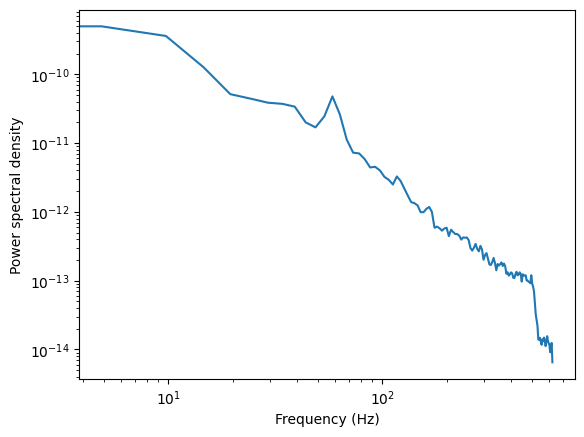

In [32]:
psd_lfp_trials = []

# select which channel to get the lfp trace from
ichan = 8

# loop through the first 5 trials
for itrial in range(0,5,1):

    lfp_trace = lfp_trials[ichan, itrial]

    # calculate the power spectrum for this lfp trace
    freqs, psd_lfp_trial = signal.welch(lfp_trace, fs = sampling_frequency_lfp)
    
    # store the psd calculated for lfp trace in this trial
    psd_lfp_trials.append(psd_lfp_trial)

psd_lfp_trial_avg = np.mean(psd_lfp_trials, axis = 0)

plt.loglog(freqs, psd_lfp_trial_avg)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density');

**Exercise**: Loop through trials 5 to 10 and calculate the frequency spectrum for the LFP trace from channel at **index 20** in each trial. Store the results in a list. Calculate the trial averaged frequency spectrum and plot it against the frequencies (`freqs`).

In [33]:
# solution


**Exercise**: Loop through all (75) trials, calculate the frequency spectrum for the LFP trace from channel at index 8 in each trial, and store the results in a list. Calculate the trial averaged frequency spectrum and plot it against the frequencies (`freqs`).

*Hint:* Instead of writing 75 in the range of the loop, you can use the `np.shape(data)[some_number]` or `data.shape[some_number]` to get the number of trials in the array containing lfp traces from all trials and channels. Trials are on dimension 1.

In [34]:
# solution


**Example**: Loop through all trials and calculate the frequency spectrum for the **LGN** spikes of the cell at index 5. Store the results in a list and calculate and plot the trial averaged frequency spectrum of the spikes of this cell.

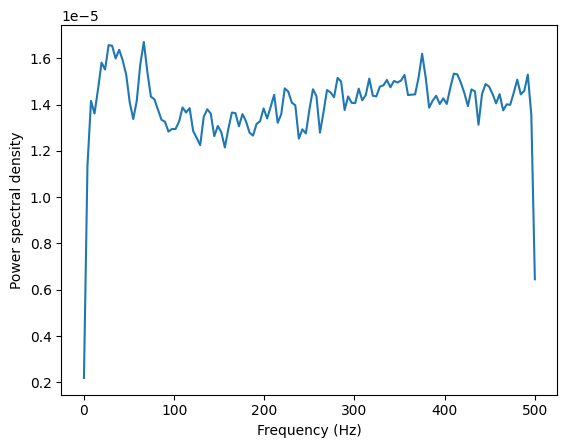

In [35]:
# solution

icell = 5

psd_spikes_LGN_all_trials = []
for itrial in range(spike_counts_LGN.shape[1]):
    spikes = spike_counts_LGN[icell, itrial]
    freqs, psd = signal.welch(spikes, sampling_frequency_spikes)

    psd_spikes_LGN_all_trials.append(psd)

psd_spikes_LGN_trial_avg = np.mean(psd_spikes_LGN_all_trials, axis = 0)

plt.plot(freqs, psd_spikes_LGN_trial_avg)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density');

**Exercise**: Loop through all trials and calculate the frequency spectrum for the **V1** spikes of the cell at index 5. Store the results in a list and calculate and plot the trial averaged frequency spectrum of the spikes of this cell.

In [36]:
# solution


**Exercise**: Loop through **all cells** and calculate the frequency spectrum for the **LGN** spikes of each cell in the first trial (`itrial = 0`) and store the results in a list. Calculate and plot the **population averaged** frequency spectrum of the spikes from all cells in this single trial.

In [37]:
# solution


## Section 4

### Nested For Loops for Multidimensional Data

If you need to go through both different channels and trials or both different cells and trials for an analysis, you will need to use a loop within a loop, or a nested for loop.

| Code                                         | Description                                                          |
| ---                                          | ---                                                                  |
| `for x_i in x:` <br> &nbsp;&nbsp;&nbsp;&nbsp; `for y_i in y`: <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `print(x_i, y_i)` | Print every element `x_i` and `y_i` in the collections `x` and `y`|
| `new_list = []` or `new_list = list()`| Initialize an empty list named `new_list` |
| `new_list.append(element)`| Append an element to the list `new_list` |
| `np.mean(data, axis = (dim_num))` or `data.mean(axis = dim_num)` | Calculate the average of the data across the `dim_num` dimension of the array. |
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` defines the colormap and the interpolation applied to the plot, respectively. |


**Example** Loop through **both** the cells and the trials and calculate the power spectrum for the **LGN** spike count of each cell in each trial. Store the resulting power spectra for each cell and trial in lists. Calculate the trial average and make a 2D colormap plot of the results with frequencies on the x-axis and cells on the y-axis.

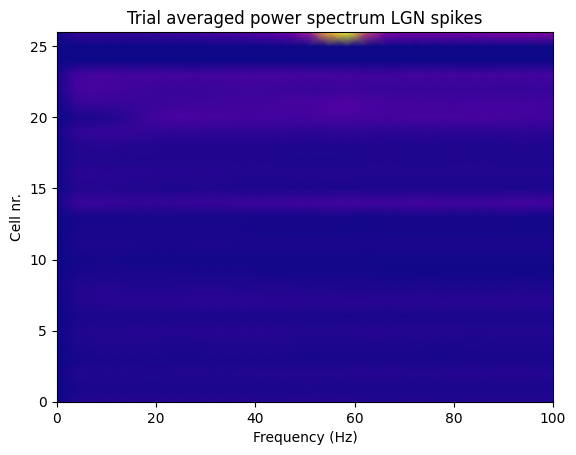

In [38]:
psd_spikes_LGN = []
for icell in range(spike_counts_LGN.shape[0]):
    psd_spikes_LGN_all_trials = []
    for itrial in range(spike_counts_LGN.shape[1]):
        spikes = spike_counts_LGN[icell, itrial]
        freqs, psd = signal.welch(spikes, sampling_frequency_spikes)

        psd_spikes_LGN_all_trials.append(psd)

    psd_spikes_LGN.append(psd_spikes_LGN_all_trials)

psd_spikes_LGN_trial_avg = np.mean(psd_spikes_LGN, axis = 1)

cell_nrs_LGN = np.arange(spike_counts_LGN.shape[0])
plt.pcolormesh(freqs, cell_nrs_LGN, psd_spikes_LGN_trial_avg, cmap='plasma', shading='gouraud')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Cell nr.')
plt.title('Trial averaged power spectrum LGN spikes');

**Exercise** Loop through **both** the cells and the trials and calculate the power spectrum for the **LM** spike count (`spike_counts_LM`) of each cell in each trial. Store the resulting power spectra for each cell and trial in lists. Calculate the trial average and make a 2D colormap plot of the results with frequencies on the x-axis and cells on the y-axis.

In [39]:
# solution


**Exercise** Loop through **both** the cells and the trials and calculate the power spectrum for the **V1** spike count (`spike_counts_V1`) of each cell in each trial. Store the resulting power spectra for each cell and trial in lists. Calculate the trial average and make a 2D colormap plot of the results with frequencies on the x-axis and cells on the y-axis.

In [40]:
# solution


**Exercise** Loop through *both* the channels *and* the trials and calculate the frequency spectrum for all LFP traces. Store the resulting power spectra. Calculate the trial average, and make a 2D colormap plot of the results with frequencies on the x-axis and cells on the y-axis.

NB: Make sure to use the sampling frequency for the LFP (`sampling_frequency_lfp`) in the function for Welch's method.

In [41]:
# solution
